In [35]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state

# Turn down for faster convergence
t0 = time.time()
train_samples = 4000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

coef_idxs = np.array([3, 7])
X = X[(y=='3')|(y=='7'),:] ### With two classes, the clf is binary hence only one set of coef
y = y[(y=='3')|(y=='7')]

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

In [41]:
scaler = MinMaxScaler()
X_train = 1.0 - scaler.fit_transform(X_train)
X_test = 1.0 - scaler.transform(X_test)

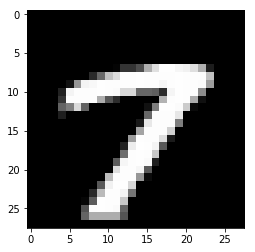

In [42]:
plt.imshow(X_train[0,:].reshape(28,28), cmap=plt.cm.Greys)

In [2]:
# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="none", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
coef_sign_= np.sign(clf.coef_)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)

c:\Users\Martin\.conda\envs\python36_jupyter\lib\site-packages\sklearn\linear_model\_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "


In [19]:
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

Sparsity with L1 penalty: 24.11%
Test score with L1 penalty: 0.9771


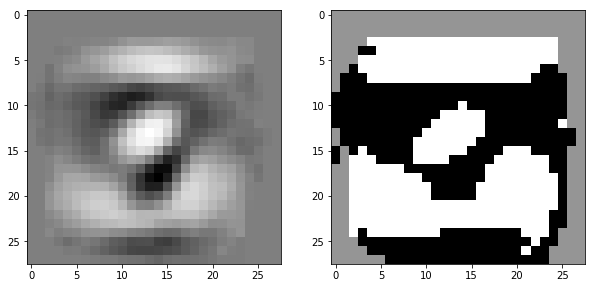

In [18]:
plt.figure(figsize=(10, 5))
spl = plt.subplot(1,2,1)
spl.imshow(clf.coef_.reshape(28,28), cmap=plt.cm.Greys)
spl = plt.subplot(1,2,2)
spl.imshow(coef_sign_.reshape(28,28), cmap=plt.cm.Greys)
plt.show()

In [34]:
np.std(X_train[0,:])

1.2345097577674076

(-0.5, 279.5, 279.5, -0.5)

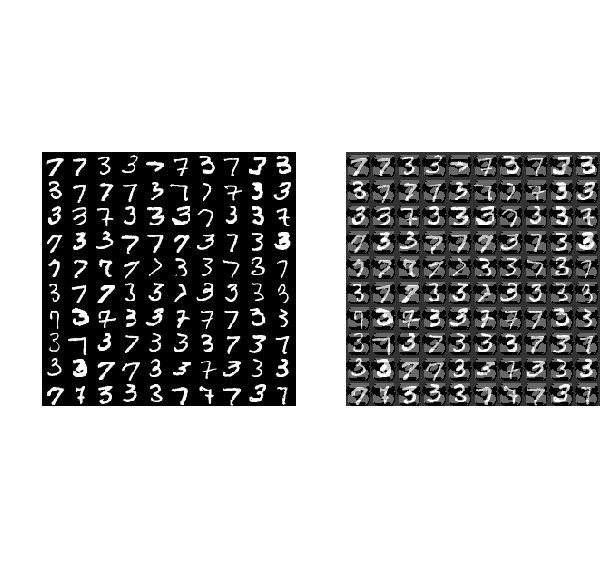

In [126]:
num_grid = 10
num_grid_sq = int(num_grid**2)
X_grid = X_train[0:num_grid_sq, :].reshape(num_grid_sq, 28, 28)
X_nums_grid = np.zeros((num_grid*28, num_grid*28))
X_nums_grid_adv = np.zeros((num_grid*28, num_grid*28))
epsilon = 0.25
for i in range(num_grid):
    n0 = 28*i
    for j in range(num_grid):
        m0 = 28*j
        idx = 10*i + j
        X_nums_grid[n0:(n0+28), m0:(m0+28)] = X_grid[idx, :, :]
        X_nums_grid_adv[n0:(n0+28), m0:(m0+28)] = X_grid[idx, :, :] + epsilon*coef_sign_.reshape(28,28)



plt.figure(figsize=(10, 10))
spl = plt.subplot(1,2,1)
plt.imshow(X_nums_grid, cmap=plt.cm.Greys)
plt.axis('equal')
plt.axis('off')

spl = plt.subplot(1,2,2)
plt.imshow(X_nums_grid_adv, cmap=plt.cm.Greys)
plt.axis('equal')
plt.axis('off')